# Gradient descent with Goldstein-Price line-search in dimension one


In [3]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 100  # parameter for resolution of graphics
import time

v = 2  # variant corresponding to the number of the function below
Maxiter = 1000 # Number of iterations
x0 = 2.5 # Initialization
a = -2.5   # Lower bound for the plot interval
b = 2.5    # Upper bound for the plot interval
Tol = 1e-15

InitStep = 1  # initial step
m1 = 0.1    #Parameters for Goldstein-Price
m2 = 0.9

## Various objective functions

Here we consider multiple functions to be tested with Newton's method

Case 0: $f(x) = x^2$ (quadratic function, convergence in $1$ iteration)

Case 1: $f(x) = x^6/6-x^2/2+x$ (here the choice of the initialization is important)

Case 2: $f(x) = x^2-\sin x$ 

Case 3: $f(x) = x^2+\exp x$

Case 4: $f(x) = x^4$ (this does not verify the non-degeneracy hypothesis: quadratic convergence is not attained)

Case 5: $f(x) = \sqrt{1+x^2}$ (here the choice of initialization is important: for $|x|<1$ we have cubic convergence, while for $|x|\geq 1$ the algorithm diverges)

In [4]:
def fun(x,v):                   # function definition
    if v==0:
        return x**2
    if v==1:
        return x**6/6-x**2/2+x
    if v==2:
        return x**2-np.sin(x)
    if v==3:
        return x**2+np.exp(x)
    if v==4:
        return x**4
    if v==5:
        return np.sqrt(1+x**2)
def der(x,v):                   # first derivative
    if v==0:
        return 2*x
    if v==1:
        return x**5-x+1
    if v==2:
        return 2*x-np.cos(x)
    if v==3: 
        return 2*x+np.exp(x)
    if v==4:
        return 4*x**3
    if v==5:
        return x/np.sqrt(1+x**2)
def der2(x,v):                  # second derivative
    if v==0: 
        return 2
    if v==1:
        return 5*x**4-1
    if v==2: 
        return 2+np.sin(x)
    if v==3:
        return 2+np.exp(x)
    if v==4:
        return 12*x**2
    if v==5:
        return 1/np.sqrt(1+x**2)**3

# List of optimizers for the above functions
if v==0:
    analytic = 0
    p=1
if v==1:
    analytic = -1.1673039782614187
    p=1
if v==2:
    analytic = 0.45018361129487355
    p=1
if v==3:
    analytic = -0.35173371124919584
    p=1
if v==4:
    analytic = 0
    p=1
if v==5:
    analytic = 0
    p=1

## Algorithm: Gradient Goldstein-Price line search

<div style="background-color:lightblue;margin:20px;padding:10px;border-radius:10px;border-width:2px;border-color:black;box-shadow:5px 5px;width:95%">

 **Initialization:** Start with $t_l=t_r=0$ and pick an initial $t>0$.

 **Iterate:** 
 - **Step 1**
    - **if** (a) then exit: you found a good $t$
    - **if** (b) then $t_r = t$: you found a new upper bound for $t$
    - **if** (c) then $t_l = t$: you found a good new lower bound for $t$
 - **Step 2**
    - **if** no valid $t_r$ exists then choose a new $t>t_r$
    - **else** choose a new $t \in (t_l,t_r)$
   </div>


Recall the three conditions

$\star$ $m_1,m_2 \in (0,1)$ are chosen constants such that $m_1<0.5$ and $m_2>0.5$.

(a) $m_2 q'(0) \leq \frac{q(t)-q(0)}{t} \leq m_1 q'(0)$ (then we have a good $t$)

(b) $m_1q'(0)< \frac{q(t)-q(0)}{t}$ (then $t$ is too big)

(c) $\frac{q(t)-q(0)}{t}<m_2q'(0)$ (then $t$ is too small)

<div style="background-color:lightblue;margin:20px;padding:10px;border-radius:10px;border-width:2px;border-color:black;box-shadow:5px 5px;width:95%">

 **Initialization:** Choose the starting point $x_0$ and the step $t>0$.

 **Step $i$:** 
   - Compute $f(x_{i-1}),f'(x_{i-1})$
   - compute the step size using the Goldstein-Price rule: consider the initial step $t = t_0$, parameters $m_1<0.5, m_2>0.5$, and consider the initial bounds equal to zero: $t_l=0,t_r=0$ and pick an initial $t>0$.
   - replace $i$ with $i+1$ and loop
</div>

**Remarks** 

1. You should stop the line search when the step size is too small
2. If the difference $|f(x_i)-f(x_{i-1})|$ is too small you may decide to stop the optimization algorithm.
<!--3. You should write the condition in the line-search loop so that you do not compare something with the gradient squared: note that $q'(0) = f'(x)d = -(f'(x))^2$ when $d=-f'(x)$. If you do this, the algorithm will stop when $|f'(x)|<\sqrt{\varepsilon}$ which means you won't get precision better than the square root of the machine epsilon (typically around $10^{-8}$). You can use square roots when the quantities are positive to avoid this behavior. -->

In [5]:
def GD(f, df, x0, tol, maxiter, m1, m2):
    phist = []
    vhist = []
    ghist = []
    phist.append(x0)  # Create an array which holds the optimization history

    val = f(x0, v)
    d = -df(x0, v)
    #d = d/abs(d)
    vhist.append(val)
    ghist.append(d)
    iter = 1
    step = 1/2
    prevval = val

    while abs(d) >= tol:
        #Line search
        tl = 0
        tr = 0
        t = 1
        #np.sqrt(abs((f(x0+step*d,v)-val)))/step<np.sqrt(abs(-(m1*(d*d))))
        while (1 == 1):
            qt = f(x0 + t * d, v)
            qp = -d * d  # here this is q'(0)
            #print(tl," ",tr)
            if ((qt - val) / t <= (m1 * qp)) and ((qt - val) / t >= (m2 * qp)):
                step = t  # we found a good step
                break
            if ((qt - val) / t > (m1 * qp)):
                # step too big
                tr = t
            if ((qt - val) / t < (m2 * qp)):
                # step too small
                tl = t
            if (tr == 0):
                t = 2 * tl
            else:
                t = 0.5 * (tl + tr)
            if abs(tr - tl) <= tol:
                break

        x0 = x0 + step * (d)
        val = f(x0, v)
        d = -df(x0, v)
        #d = d/abs(d)

        print("Iter: ", iter, "| Val: ", val, "| Step: ", step, " Grad: ",
              abs(d))

        phist.append(x0)
        vhist.append(val)
        ghist.append(d)
        iter = iter + 1
        if (iter > maxiter):
            print('Maximum number of iterations reached!')
            break

        prevval = val
        if (abs(d) < Tol):
            print('Algorithm converged!')
    return phist, vhist, ghist


In [8]:
def GD_Armijo(f, df, x0, tol, maxiter, m1, m2):
    phist = []
    vhist = []
    ghist = []
    phist.append(x0)  # Create an array which holds the optimization history

    val = f(x0, v)
    d = -df(x0, v)
    #d = d/abs(d)
    vhist.append(val)
    ghist.append(d)
    iter = 1
    step = 1/2
    prevval = val
    q0 = df(0, v)

    while abs(d) >= tol:
        #Line search
        tl = 0
        tr = 0
        t = 1
        #np.sqrt(abs((f(x0+step*d,v)-val)))/step<np.sqrt(abs(-(m1*(d*d))))
        while (1 == 1):
            qt = f(x0 + t * d, v)
            #print(tl," ",tr)
            if ((qt - q0) / t <= (m1 * q0)) and ((qt - val) / t >= (m2 * q0)):
                step = t  # we found a good step
                break
            if ((qt - q0) / t > (m1 * q0)):
                # step too big
                tr = t
            if ((qt - q0) / t < (m2 * q0)):
                # step too small
                tl = t
            if (tr == 0):
                t = 2 * tl
            else:
                t = 0.5 * (tl + tr)
            if abs(tr - tl) <= tol:
                break

        x0 = x0 + step * (d)
        val = f(x0, v)
        d = -df(x0, v)
        #d = d/abs(d)

        print("Iter: ", iter, "| Val: ", val, "| Step: ", step, " Grad: ",
              abs(d))

        phist.append(x0)
        vhist.append(val)
        ghist.append(d)
        iter = iter + 1
        if (iter > maxiter):
            print('Maximum number of iterations reached!')
            break

        prevval = val
        if (abs(d) < Tol):
            print('Algorithm converged!')
    return phist, vhist, ghist


Iter:  1 | Val:  0.5504027216361487 | Step:  0.5  Grad:  1.7219817865497418
Iter:  2 | Val:  -0.2323378562848957 | Step:  0.5  Grad:  0.02497180437488078
Iter:  3 | Val:  -0.23245941059881034 | Step:  0.5  Grad:  0.0054778058751464576
Iter:  4 | Val:  -0.23246528462013832 | Step:  0.5  Grad:  0.0011896078496956841
Iter:  5 | Val:  -0.23246556139278457 | Step:  0.5  Grad:  0.0002589198618407895
Iter:  6 | Val:  -0.23246557450676583 | Step:  0.5  Grad:  5.6327162022862254e-05
Iter:  7 | Val:  -0.23246557512737806 | Step:  0.5  Grad:  1.225507266311432e-05
Iter:  8 | Val:  -0.23246557515675598 | Step:  0.5  Grad:  2.6662692855783376e-06
Iter:  9 | Val:  -0.23246557515814656 | Step:  0.5  Grad:  5.800885365392361e-07
Iter:  10 | Val:  -0.23246557515821237 | Step:  0.5  Grad:  1.262071872565329e-07
Iter:  11 | Val:  -0.2324655751582155 | Step:  0.5  Grad:  2.745832206052512e-08
Iter:  12 | Val:  -0.23246557515821564 | Step:  0.5  Grad:  5.973981642704018e-09
Number of iterations:  13
Final 

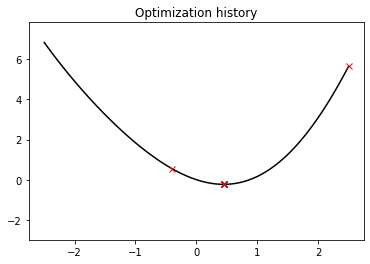

In [13]:
pp,vv,gg = GD_Armijo(fun,der,x0,1e-8,Maxiter,m1,m2)

print('Number of iterations: ',len(pp))
print('Final position: ',pp[-1])
print('Analytical sol: ',analytic)

uplim = max(fun(a,v),fun(b,v))+1   # set limits for the plot window
dnlim = -3
t1 = np.linspace(a,b,100)          # Create a discretization to be used with the plots
plt.figure(1)
plt.ylim([dnlim,uplim])            # Set upper bounds for the figure

plt.plot(t1,fun(t1,v),'k')         # Plot the function to be optimized on the interval [a,b]
plt.plot(pp,vv,'xr')

plt.title('Optimization history')
plt.show()

After the optimization loop, the convergence history and the order of convergence is computed. For each one of the functions a value $x^*$ close to the analytical solution is provided. The order of convergence is obtained by plotting the next error $|x_{n+1}-x^*|$ as a function of the previous error $|x_n-x^*|$. Since we want to find an eventual power law between these two, a log-log scale is used, since this turns power functions $x \mapsto Cx^p$ into lines with slope $p$.

(Note that if the number of iterations is too small (the method converged fast due to some miracle) then you won't be able to see anything in the error analysis.)

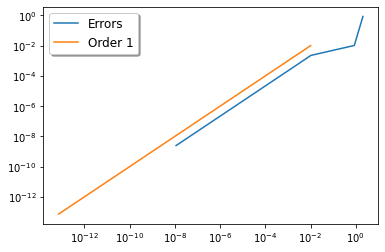

Ratio of convergence (approx) =  0.217565430339959
Errors:  [2.04981639e+00 8.50755419e-01 1.02354742e-02 2.25042798e-03
 4.88474957e-04 1.06328968e-04 2.31309627e-05 5.03261828e-06
 1.09491806e-06 2.38216587e-07 5.18276813e-08 1.12759123e-08
 2.45324872e-09]


In [8]:
Niter = len(pp)+1# Error analysis   
dis = np.linspace(1,Niter,Niter+1)
points = np.array(pp)
errors = abs(points-analytic)          # Compute differences between current points and the optimum
if(dis.size>10):
    dis2 = dis[0:7]
else:
    dis2 = dis
sq  = 0.01**dis2                      # Construct curve of order 1
#sq = 0.01*sq/sq[0]*errors[0]
#sq = sq/sq[-1]*errors[-1]
sq2 = 100*sq**2                      # Construct curve of order 2
#sq2 = sq2/sq2[-1]*errors[-1]
sq3 = 100*sq**3                      # Construct curve of order 3

plt.figure(2)
plt.loglog(errors[:-1:],errors[1:],label='Errors')  # Plot the errors in log-log plot
#plt.loglog(sq,sq2,label='Order 2')                  # Plot order curves for comparison
plt.loglog(sq,sq,label='Order 1')
#plt.loglog(sq,sq3,label='Order 3')
plt.legend(loc='best', shadow=True, fontsize='large')  # Show legend
plt.show()                                          # Show plot

ratio = errors[-1]/errors[-2]**p
print("Ratio of convergence (approx) = ",ratio)
print("Errors: ",errors)